Este notebook está diseñado para mostrar el progreso durante el desarrollo del proyecto. En este sentido, no es directamente traducible a un script.

# Preliminares

## Creación de directorios, descompresión de archivo

In [ ]:

#importaciones y montaje del drive
import os.path
import shutil
from distutils.dir_util import copy_tree
from google.colab import drive
drive.mount('/content/gdrive')


"\n#importaciones y montaje del drive\nimport os.path\nimport shutil\nfrom distutils.dir_util import copy_tree\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
#enlace simbólico
!ln -s /content/gdrive/My\ Drive/ /mydrive
#Importación de los archivos desde el drive
!cp /mydrive/Deep_Learning_2021/Data/jpg_by_gender.zip /content/
#unzip de los archivos
os.mkdir('/content/full_data')
!unzip /content/jpg_by_gender.zip -d /content/full_data > /dev/null
original_mdataset_dir='/content/full_data/male'
original_fdataset_dir='/content/full_data/female'


"\nfrom keras.preprocessing.image import ImageDataGenerator\n#enlace simbólico\n!ln -s /content/gdrive/My\\ Drive/ /mydrive\n#Importación de los archivos desde el drive\n!cp /mydrive/Deep_Learning_2021/Data/jpg_by_gender.zip /content/\n#unzip de los archivos\nos.mkdir('/content/full_data')\n!unzip /content/jpg_by_gender.zip -d /content/full_data > /dev/null\noriginal_mdataset_dir='/content/full_data/male'\noriginal_fdataset_dir='/content/full_data/female'\n"

In [ ]:

base_dir = '/content/unsplit_data'
os.mkdir(base_dir)
train_dir='/content/unsplit_data/train'
test_dir='/content/unsplit_data/test'
os.mkdir(train_dir)
os.mkdir(test_dir)

total_male=len(os.listdir(original_mdataset_dir))
total_female=len(os.listdir(original_fdataset_dir))
train_proportion=0.7
validation_proportion=0.15
test_proportion=0.15
split_validation_proportion=validation_proportion/(validation_proportion+train_proportion)

#y a copiar todo sobre ese directorio
fnames = ['male-{}.jpg'.format(i) for i in range(1,int(total_male*(train_proportion+validation_proportion)))]
for fname in fnames:
  src = os.path.join(original_mdataset_dir, fname)
  dst = os.path.join(train_dir, fname)
  shutil.copyfile(src, dst)
fnames = ['female-{}.jpg'.format(i) for i in range(1,int(total_female*(train_proportion+validation_proportion)))]
for fname in fnames:
  src = os.path.join(original_fdataset_dir, fname)
  dst = os.path.join(train_dir, fname)
  shutil.copyfile(src, dst)
  fnames = ['male-{}.jpg'.format(i) for i in range(int(total_male*(train_proportion+validation_proportion)),total_male)]
for fname in fnames:
  src = os.path.join(original_mdataset_dir, fname)
  dst = os.path.join(test_dir, fname)
  shutil.copyfile(src, dst)
fnames = ['female-{}.jpg'.format(i) for i in range(int(total_female*(train_proportion+validation_proportion)),total_female)]
for fname in fnames:
  src = os.path.join(original_fdataset_dir, fname)
  dst = os.path.join(test_dir, fname)
  shutil.copyfile(src, dst)


"\nbase_dir = '/content/unsplit_data'\nos.mkdir(base_dir)\ntrain_dir='/content/unsplit_data/train'\ntest_dir='/content/unsplit_data/test'\nos.mkdir(train_dir)\nos.mkdir(test_dir)\n\ntotal_male=len(os.listdir(original_mdataset_dir))\ntotal_female=len(os.listdir(original_fdataset_dir))\ntrain_proportion=0.7\nvalidation_proportion=0.15\ntest_proportion=0.15\nsplit_validation_proportion=validation_proportion/(validation_proportion+train_proportion)\n\n#y a copiar todo sobre ese directorio\nfnames = ['male-{}.jpg'.format(i) for i in range(1,int(total_male*(train_proportion+validation_proportion)))]\nfor fname in fnames:\n  src = os.path.join(original_mdataset_dir, fname)\n  dst = os.path.join(train_dir, fname)\n  shutil.copyfile(src, dst)\nfnames = ['female-{}.jpg'.format(i) for i in range(1,int(total_female*(train_proportion+validation_proportion)))]\nfor fname in fnames:\n  src = os.path.join(original_fdataset_dir, fname)\n  dst = os.path.join(train_dir, fname)\n  shutil.copyfile(src, dst

## Creación del dataframe y preparación de los datos

### Creación de los dataframes

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
#No nos gustan los número mágicos
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
TARGET_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

In [ ]:
#Labeleado y dataframe de los datos del entrenamiento
filenames = os.listdir("/content/unsplit_data/train")
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'male':
        categories.append('male')
    else:
        categories.append('female')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
train_samples = df.shape[0]
print("Number of elements in the train datasatet: ", train_samples)

Number of elements in the train datasatet:  35582


In [ ]:
#también le hacemos un dataframe labeleado
test_filenames = os.listdir("/content/unsplit_data/test")
test_categories = []
for test_filename in test_filenames:
    category = test_filename.split('-')[0]
    if category == 'male':
        test_categories.append('male')
    else:
        test_categories.append('female')

df_labeled_test = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})
labeled_test_samples = df_labeled_test.shape[0]
print("Labeled samples:",labeled_test_samples)

df_unlabeled_test = pd.DataFrame({'filename': df_labeled_test.loc[:,"filename"]})
unlabeled_test_samples = df_unlabeled_test.shape[0]
print("Unlabeled samples:",unlabeled_test_samples)

Labeled samples: 6280
Unlabeled samples: 6280


In [ ]:
#vamos a hacer un split en los datos de entrenamiento
train_df, validate_df = train_test_split(df, test_size=split_validation_proportion, random_state=9)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
#Utilizando esta información, definimos el número de datos por clase, por conjunto
print("Number of images per category on the train set:\n",train_df['category'].value_counts().sort_index(ascending=True),"\n")
print("Number of images per category on the validation set:\n",validate_df['category'].value_counts().sort_index(ascending=True))
total_ftraining=train_df['category'].value_counts().sort_index(ascending=True)[0]
total_mtraining=train_df['category'].value_counts().sort_index(ascending=True)[1]
total_fvalidation=validate_df['category'].value_counts().sort_index(ascending=True)[0]
total_mvalidation=validate_df['category'].value_counts().sort_index(ascending=True)[1]

Number of images per category on the train set:
 female    13666
male      15636
Name: category, dtype: int64 

Number of images per category on the validation set:
 female    2969
male      3311
Name: category, dtype: int64


### Generadores de datos

In [ ]:
#Con los dataframes definidos podemos usar sus propiedades para asignar variables importantes
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
BATCH_SIZE=32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/unsplit_data/train/", 
    x_col='filename',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 29302 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/unsplit_data/train/", 
    x_col='filename',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 6280 validated image filenames belonging to 2 classes.


In [ ]:
#Generador de predicción
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df_unlabeled_test, 
    "/content/unsplit_data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=TARGET_SIZE,
    batch_size=1,
    shuffle=False
)

Found 6280 validated image filenames.


In [ ]:
#Generador de prueba
labeled_test_datagen = ImageDataGenerator(rescale=1./255)
labeled_test_generator = labeled_test_datagen.flow_from_dataframe(
    df_labeled_test, 
    "/content/unsplit_data/test/", 
    x_col='filename',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='binary',
    batch_size=1
)

Found 6280 validated image filenames belonging to 2 classes.


# Creación y entrenamiento del modelo

## Funciones de creación

El objetivo de este notebook es crear un modelo que incorpore dropouts. Así que eso haremos.

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks

# Creación del modelo
def create_final_model(learn_rate,dropout):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((3, 3)))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['acc'])
  return model

def create_final_model2(learn_rate,dropout):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((3, 3)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((3, 3)))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['acc'])
  return model

In [ ]:
#Variables para evitar, de nuevo, números mágicos:
STEPS_PER_EPOCH=int((total_ftraining+total_mtraining)/BATCH_SIZE)
VALIDATION_STEPS=int((total_fvalidation+total_mvalidation)/BATCH_SIZE)
EPOCHS=30
SAVE_PERIOD = 5


#Callbacks. Añadiremos, como es natural, callbacks de checkpoints, de early stopping,
#y como novedad, de reducción de learning rate.
EARLY_STOPPING = callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=6)

checkpoint_path = "/mydrive/Deep_Learning_2021/gender_chks/gender_chk_full_final/3conv1-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
CHECK_CALLBACK = callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH))


REDUCE_LR = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)

In [ ]:
# Creamos el modelo
LEARNING_RATE=0.001
DROPOUT=0.3
model = create_final_model2(LEARNING_RATE,DROPOUT)
#Y a ver el resumen
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 18, 18, 128)      

## Entrenamiento

In [ ]:

import tensorflow as tf
#Para cargar el último punto de control
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest
#Para recuperarlo y probarlo
model = create_final_model(LEARNING_RATE,DROPOUT)
# Load the previously saved weights
model.load_weights(latest)
# Re-evaluate the model
loss, acc = model.evaluate(labeled_test_generator)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
#Para continuar entrenamiento, basta con volver a usar el método fit con los epochs


'\nimport tensorflow as tf\n#Para cargar el último punto de control\nlatest = tf.train.latest_checkpoint(checkpoint_dir)\nlatest\n#Para recuperarlo y probarlo\nmodel = create_final_model(LEARNING_RATE,DROPOUT)\n# Load the previously saved weights\nmodel.load_weights(latest)\n# Re-evaluate the model\nloss, acc = model.evaluate(labeled_test_generator)\nprint("Restored model, accuracy: {:5.2f}%".format(100 * acc))\n#Para continuar entrenamiento, basta con volver a usar el método fit con los epochs\n'

In [ ]:
history = model.fit(
  train_generator,
  steps_per_epoch=STEPS_PER_EPOCH,
  epochs=EPOCHS,
  validation_data=validation_generator,
  validation_steps=VALIDATION_STEPS,
  callbacks=[CHECK_CALLBACK,EARLY_STOPPING,REDUCE_LR])

Epoch 1/30
915/915 [==============================] - 55s 59ms/step - loss: 0.3290 - acc: 0.8755 - val_loss: 0.2725 - val_acc: 0.8999
Epoch 2/30
915/915 [==============================] - 54s 59ms/step - loss: 0.2012 - acc: 0.9284 - val_loss: 0.4034 - val_acc: 0.8817
Epoch 3/30
915/915 [==============================] - 54s 59ms/step - loss: 0.1638 - acc: 0.9457 - val_loss: 0.1752 - val_acc: 0.9408
Epoch 4/30
915/915 [==============================] - 54s 59ms/step - loss: 0.1456 - acc: 0.9510 - val_loss: 0.2050 - val_acc: 0.9332
Epoch 5/30
915/915 [==============================] - ETA: 0s - loss: 0.1249 - acc: 0.9602
Epoch 00005: saving model to /mydrive/Deep_Learning_2021/gender_chks/gender_chk_full_final/3conv1-0005.ckpt
915/915 [==============================] - 54s 59ms/step - loss: 0.1249 - acc: 0.9602 - val_loss: 0.3543 - val_acc: 0.9047
Epoch 6/30
915/915 [==============================] - 54s 59ms/step - loss: 0.1126 - acc: 0.9636 - val_loss: 0.1321 - val_acc: 0.9584
Epoch 7/

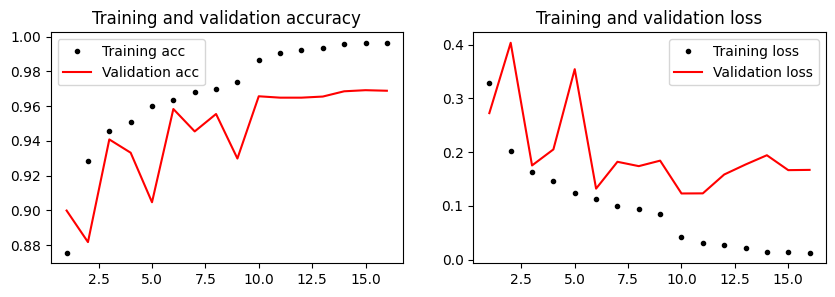

In [ ]:
#A graficar como nos fue en el entrenamiento
import matplotlib.pyplot  as plt
from keras.utils.vis_utils import plot_model
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use('default')
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(epochs, acc, 'k.', label='Training acc')
ax.plot(epochs, val_acc, 'r', label='Validation acc')
ax.title.set_text('Training and validation accuracy')
ax.legend()

ax2.plot(epochs, loss, 'k.', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.title.set_text('Training and validation loss')
ax2.legend()

In [ ]:
#guardamos el modelo
savedir='/mydrive/Deep_Learning_2021/gender_chks/gender_chk_full_final/gender_model_final3conv2.h5'
model.save(savedir)

In [ ]:
#Para recuperarlo:
from keras.models import load_model
savedir='/mydrive/Deep_Learning_2021/gender_chks/gender_chk_full_final/gender_model_final3conv2.h5'
model = load_model(savedir)

# Predicciones y pruebas

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(unlabeled_test_samples))

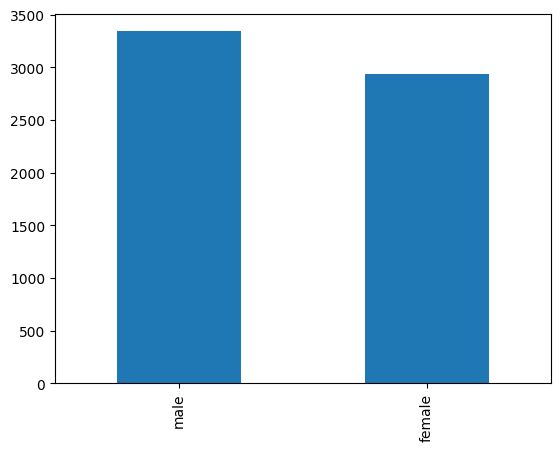

In [ ]:
df_unlabeled_test['category'] = np.around(predict)
df_unlabeled_test['category'] = df_unlabeled_test['category'].replace({ 1.0: 'male', 0.0: 'female' })
df_unlabeled_test['category'].value_counts().plot.bar()

In [ ]:
sample_test = df_unlabeled_test.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/unsplit_data/test/"+filename, target_size=TARGET_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Real: '+filename.split('-')[0] +'\n'+ 'Predicted: ' + "{}".format(category))
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Para probarlo, de nuevo, en lugar del evaluate() usamos evaluate_generator().
loss, acc = model.evaluate(labeled_test_generator)
print('Full model, accuracy: {:5.2f}%'.format(100 * acc))

6280/6280 [==============================] - 21s 3ms/step - loss: 0.2749 - acc: 0.9599
Full model, accuracy: 95.99%
